# Analyzing Helsinki City Feedback with Watson NLP

This notebook demonstrates how to analyze customer feedback using Watson NLP in Watson Studio.

The data used in this notebook is taken from the publicly available Helsinki City Feedback at http://dev.hel.fi/apis/open311 but requires you to request read access.  A feedback contains a citizen’s free-form description in the field called 'text'. 

A sample input file 'helsinki-feedback-data.csv' is provided in the same location as this notebook and should be loaded as a data asset to the same Project in Watson Studio.


## What you'll learn in this notebook

Watson NLP offers so-called blocks for various NLP tasks. This notebooks shows:

- **Sentiment classification** with the _Sentiment classification model_ using multi-lingual BERT (`sentiment_sentence-bert_multi_stock`). This block classifies the sentiment of a sentence as *positive*, *neutral*, *negative*.
- **Entity extraction** with the _Entity mentions block_ using the multi-lingual BERT model (`entity-mentions_bert_multi_stock`). This block extracts mentions of entities like *Location*, *Organization* or *Duration* from the input text.
- **Dictionary-based term extraction** with the _Rule-based extractor_  (`watson_nlp.resources.feature_extractor.RBR`). This allows you to train a custom extraction model based on given dictionaries.

The Watson NLP Block catalogue at https://eu-de.dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/watson-nlp-block-catalog.html describes all the blocks and the naming convention of the models.

## How to adapt this notebook to another language

1) Syntax analysis is a language-specific model implemented by izumo parser. Many Watson NLP models take as input the output of Syntax analysis. Check the support for **Tokenization, Lemmatization and Part-of-Speech tagging** for your language at  https://eu-de.dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/watson-nlp-block-syntax.html

This notebook uses: 

`syntax_izumo_<lc>_stock`
if supported for your language, replace the language code 'fi' with the code for your language in the following call in this notebook: 

`watson_nlp.load(watson_nlp.download('syntax_izumo_fi_stock'))` 

2) Check the **supported languages for pre-trained models**.

This notebook uses:

Sentiment (BERT) `sentiment_sentence-bert_multi_stock`
Check https://eu-de.dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/watson-nlp-block-sentiment.html
if supported for your language, use this multi-lingual model as is

Machine-learning-based extraction for general entities (BERT) `entity-mentions_bert_multi_stock`
Check https://eu-de.dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/watson-nlp-block-entity-enhanced.html
if supported for your language, use this multi-lingual model as is

3) Check the **supported languages for creating your own models** for your language at 
https://eu-de.dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/watson-nlp-create-model.html

This notebook uses: 

Custom dictionary model `watson_nlp.resources.feature_extractor.RBR`
if supported for your language, replace the language code 'fi' with the code for your language in the following calls in this notebook: 

`watson_nlp.resources.feature_extractor.RBR.train(RBR_dicts_folder, language='fi', dictionaries=[dictionary,])`

`trained_dict_RBR.executor.get_raw_response(feedback_text, language='fi')`

4) Construct a csv data set in your language with a column of free-text data you want to analyse. Replace the name of the free-text column in this notebook:

`text_col = 'text'`


## Table of Contents


1.	[Before you start](#beforeYouStart)
2.	[Load the data](#loadData)
3.	[Sentiment classification](#sentiment)
4.  [Entity extraction](#entities)
5.  [Custom term extraction using dictionaries](#dictionaries)
6.  [Summary](#summary)


<a id="beforeYouStart"></a>
## Before you start

Before you can begin working on this notebook in Watson Studio in Cloud Pak for Data as a Service, you need to ensure that the project token is set so that you can access the project assets via the notebook.

When this notebook is added to the project, a project access token should be inserted at the top of the notebook in a code cell. If you do not see the cell above, add the token to the notebook by clicking **More > Insert project token** from the notebook action bar.  By running the inserted hidden code cell, a project object is created that you can use to access project resources.

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)

Note that you can step through the notebook execution cell by cell, by selecting Shift-Enter. Or you can execute the entire notebook by selecting **Cell -> Run All** from the menu.


Begin by importing and initializing Watson NLP and some helper libraries that are used throughout the notebook.

<a id="loadData"></a>
## Load Data

In [3]:
import watson_nlp
import pandas as pd

In [4]:
# load feedback data set into a dataframe
buffer = project.get_file("helsinki-feedback-data.csv")

# In this example, we take only the first 1000 feedback rows in the dataset for further analysis. 
# Set df to df_all to run on the complete dataset.
df_all = pd.read_csv(buffer)
df_small = df_all.head(1000)
df = df_small
text_col = 'text'
df.head(5)


,service_request_id,service_code,service_notice,requested_datetime,text,agency_responsible,service_name,lat,long,media_url
0,35u23h58v89bf4b6jtfd,3561,2019-07-19T09:15:16+03:00,2019-07-26T11:34:42+03:00,Aino Achteen puiston skeittiradan molok roski...,Kaupunkiympäristö,NaN,60.225534,24.886015,NaN
1,16g1vgt13vjlqtt3j571,2806,2019-12-12T11:43:11+02:00,2019-12-13T11:30:57+02:00,Alapuolelle olisi selvyyden vuoksi hyvä saada...,Kaupunkiympäristö,City environment,60.169926,24.929297,NaN
2,32l6vq64j0ain7ihdift,2806,2019-07-27T16:20:33+03:00,2019-08-09T15:35:02+03:00,"ei erotu pimeässä, heijastava pinta puuttuu, ...",Kaupunkiympäristö,City environment,60.168575,24.921212,NaN
3,5psv8s4pjf0t1jo6h4m5,2806,2019-07-01T22:20:48+03:00,2019-07-05T09:01:44+03:00,... vaikka silloin kun vesi on matalalla? Kiit...,Kulttuuri ja vapaa-aika,City environment,60.176795,24.956236,NaN
4,2oqntdp56qiaa1qfpcj1,2806,2019-08-20T16:30:32+03:00,2019-08-26T08:25:02+03:00,...edessä on ollut pidemmän ajan työkoneita jn...,Kaupunkiympäristö,City environment,60.158044,24.951849,https://asiointi.hel.fi/palautews/rest/v1/atta...


<a id="sentiment"></a>
## Classify the sentiment for each sentence and the overall sentiment of each feedback  

Are citizens talking positively or negatively about the city? The sentiment extraction helpers extract sentiment at sentence level and predict sentiment at document level. 

In [5]:
from watson_nlp.toolkit import predict_document_sentiment

In [7]:
# Load the syntax model for Finnish (language code 'fi') and multilingual BERT sentiment model
syntax_model = watson_nlp.load(watson_nlp.download('syntax_izumo_fi_stock'))
sentiment_model = watson_nlp.load(watson_nlp.download('sentiment_sentence-bert_multi_stock'))


Helper functions to extract the sentiment in the feedback text and create a dataframe.


In [8]:
def extract_sentiment(review_text):
    # run the syntax model
    syntax_result = syntax_model.run(review_text, parsers=('token', 'lemma', 'part_of_speech'))
    # run the sentiment model on the result of the syntax analysis
    sentiment_result = sentiment_model.run_batch(syntax_result.get_sentence_texts(), syntax_result.sentences)
    
    sentence_sentiment = [(sent.sentiment_mention.span.text, sent.to_dict()['label']) for sent in sentiment_result]
    # use a helper function from the NLP toolkit to predict the document sentiment from the sentiment of the individual sentences
    document_sentiment = predict_document_sentiment(sentiment_result, 
                                                    sentiment_model.class_idxs, 
                                                    combine_approach="MEAN").to_dict()['label']
    return (sentence_sentiment, document_sentiment)

# Helper method to create a new dataframe that contains the sentiment for each review
def create_sentiment_dataframe(df):
    sentiment = df['text'].apply(lambda text: extract_sentiment(text))
    sentiment_df = pd.DataFrame.from_records(sentiment, columns=('Sentence Sentiment', 'Document Sentiment'))
    return sentiment_df


Extract the Document sentiment and display it with the agency and feedback text.

In [9]:
sentiment_df = create_sentiment_dataframe(df)

In [10]:
service_sentiment_df = df[['agency_responsible','text']].merge(sentiment_df[['Document Sentiment']], how='left', left_index=True, right_index=True)
service_sentiment_df.head(10)


,agency_responsible,text,Document Sentiment
0,Kaupunkiympäristö,Aino Achteen puiston skeittiradan molok roski...,SENT_NEGATIVE
1,Kaupunkiympäristö,Alapuolelle olisi selvyyden vuoksi hyvä saada...,SENT_NEGATIVE
2,Kaupunkiympäristö,"ei erotu pimeässä, heijastava pinta puuttuu, ...",SENT_NEUTRAL
3,Kulttuuri ja vapaa-aika,... vaikka silloin kun vesi on matalalla? Kiit...,SENT_NEUTRAL
4,Kaupunkiympäristö,...edessä on ollut pidemmän ajan työkoneita jn...,SENT_NEUTRAL
5,Kaupunkiympäristö,...hieman siivottavaa,SENT_NEGATIVE
6,Kaupunkiympäristö,...kulmasta puuttuu maksullisuus merkki,SENT_NEGATIVE
7,Kaupunkiympäristö,"...paikkamerkin kohdalla, 60°12′52″ N 24°54′4...",SENT_NEUTRAL
8,Liikenneliikelaitos,Alepapyörien iso keltainen kyltti makaa pyörie...,SENT_NEUTRAL
9,Kaupunkiympäristö,Olemme välittäneet tiedon tarkastajalle eli to...,SENT_NEUTRAL


You can look at all values for 'agency_responsible' that are available in the data set to do further analysis around these groups. You'll notice that a majority relate to `Kaupunkiympäristö` (City environment)

<AxesSubplot:>

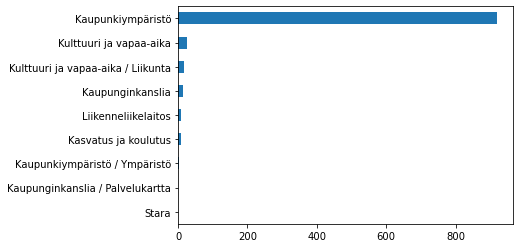

In [11]:
service_sentiment_df['agency_responsible'].value_counts().sort_values().plot(kind='barh') 

Show the relative frequency of each Sentiment value by agency_responsible:

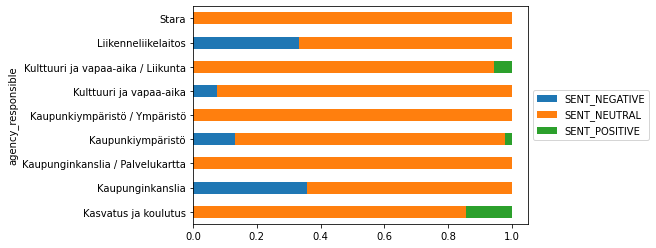

In [12]:
unstacked = service_sentiment_df.groupby('agency_responsible')['Document Sentiment'].value_counts(normalize=True).unstack()
unstacked.plot.barh(stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

<a id="entities"></a>
## Entity extraction

The feedback may contain entity mentions about entities like locations, durations, etc. In this section you will learn how to use the BERT entity mention extraction block, which extracts entity mentions out-of-the-box. 

The BERT entity mention model depends on the syntax model. Start with loading BERT, syntax was already loaded above:

In [13]:
# Load multilingual BERT entity model
bert_entity_model = watson_nlp.load(watson_nlp.download('entity-mentions_bert_multi_stock'))

The helper method first runs the syntax model and then the entity extraction model on top of the syntax result:

In [14]:
def extract_entities(feedback_text):
    # run syntax model (note to self: this does not need to run again as already run above)
    syntax_result = syntax_model.run(feedback_text, parsers=('token', 'lemma', 'part_of_speech'))
    # run the entity mention model on the result of the syntax model
    entity_mentions = bert_entity_model.run(syntax_result)
    # get text and type of entities
    entities = entity_mentions.get_mention_pairs()
    return entities

Run the entity extraction model on the feedback dataframe and show the extracted entities along with the text:

In [15]:
# run entity extraction and create a dataframe holding the results
entities = df[text_col].apply(lambda text: extract_entities(text))
entities_df = pd.DataFrame(entities)
entities_df.rename(inplace=True, columns={text_col:'Entities'})

In [16]:
# combine with the feedback dataframe
text_entities_df = df[[text_col, 'agency_responsible']].merge(entities_df, how='left', left_index=True, right_index=True)
text_entities_df.head(10)

,text,agency_responsible,Entities
0,Aino Achteen puiston skeittiradan molok roski...,Kaupunkiympäristö,"[(Aino, Facility), (Achteen puiston, Facility)..."
1,Alapuolelle olisi selvyyden vuoksi hyvä saada...,Kaupunkiympäristö,"[(HSL, Organization), (Pysäkille, Facility)]"
2,"ei erotu pimeässä, heijastava pinta puuttuu, ...",Kaupunkiympäristö,[]
3,... vaikka silloin kun vesi on matalalla? Kiit...,Kulttuuri ja vapaa-aika,[]
4,...edessä on ollut pidemmän ajan työkoneita jn...,Kaupunkiympäristö,"[(Ilman, Organization)]"
5,...hieman siivottavaa,Kaupunkiympäristö,[]
6,...kulmasta puuttuu maksullisuus merkki,Kaupunkiympäristö,[]
7,"...paikkamerkin kohdalla, 60°12′52″ N 24°54′4...",Kaupunkiympäristö,"[(60°12′52″, Measure), (24, Measure)]"
8,Alepapyörien iso keltainen kyltti makaa pyörie...,Liikenneliikelaitos,"[(Teollisuuskatu 2aA-rapun, Location)]"
9,Olemme välittäneet tiedon tarkastajalle eli to...,Kaupunkiympäristö,"[(tarkastajalle, JobTitle)]"


Let's see what type of entities are extracted from the feedback:

<AxesSubplot:>

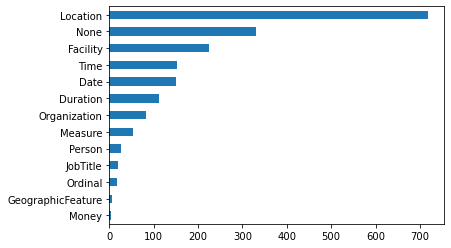

In [17]:
# helper method to extract the mention type from the (text, type) tuple
def get_entity_type(ent):
    if not pd.isna(ent):
        return ent[1]
    return 'None'

# create a separate row for each entity mention
exp_entities = text_entities_df.explode('Entities')
# extract the entity type of each mention
exp_entities['Entity Type'] = exp_entities['Entities'].apply(lambda ent: get_entity_type(ent))
# count the number of occurrences for each entity type and plot bar chart
exp_entities['Entity Type'].value_counts().head(20).sort_values().plot(kind='barh') 

Show the relative frequency of each entity type by agency_responsible:

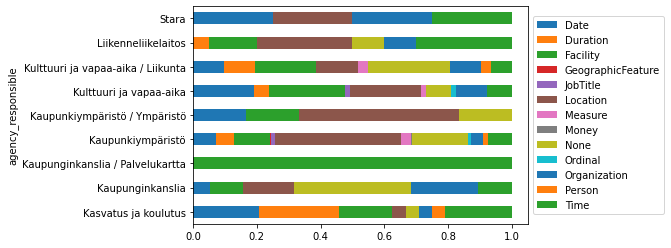

In [18]:
unstacked = exp_entities.groupby('agency_responsible')['Entity Type'].value_counts(normalize=True).unstack()
unstacked.plot.barh(stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

*Locations* are frequently mentioned in 'Kaupunkiympäristö' (City environment) agency.  Let's look at some sample texts for the Locations and Jobtitles.

In [19]:
exp_entities.query('`Entity Type` == "Location" and agency_responsible == "Kaupunkiympäristö"').head(20)

,text,agency_responsible,Entities,Entity Type
10,"/ Hakaniemen ranta, kulmassa oleva pys.kielto ...",Kaupunkiympäristö,"(Hakaniemen, Location)",Location
14,"1) Kuvan opasteesta tulisi ymmärtää, että jos ...",Kaupunkiympäristö,"(kehä I, Location)",Location
14,"1) Kuvan opasteesta tulisi ymmärtää, että jos ...",Kaupunkiympäristö,"(Malmille, Location)",Location
14,"1) Kuvan opasteesta tulisi ymmärtää, että jos ...",Kaupunkiympäristö,"(Leppävaaraan, Location)",Location
17,16.10 aamulla kaikki liikenne estetty taidenma...,Kaupunkiympäristö,"(taidenmaalarinkadulla, Location)",Location
18,2 katuvaloa pimeänä kolkkapojanpolulla ja 3 va...,Kaupunkiympäristö,"(kolkkapojanpolulla, Location)",Location
19,2 kk pyörätiellä Hiomotie 30 kohdalla. Remontt...,Kaupunkiympäristö,"(Hiomotie 30, Location)",Location
20,2 kk sitten luvattiin peittää ja tasoittaa tuk...,Kaupunkiympäristö,"(tukkutorinkuja, Location)",Location
31,69 bussilla kun tulee Jakomäen suunnasta niin ...,Kaupunkiympäristö,"(Jakomäen, Location)",Location
33,9.8.2019 Kaupunkiympäristö vastasi katukorjauk...,Kaupunkiympäristö,"(Kanneltie, Location)",Location


In [20]:
exp_entities.query('`Entity Type` == "JobTitle" and agency_responsible == "Kaupunkiympäristö"').head(20)

,text,agency_responsible,Entities,Entity Type
9,Olemme välittäneet tiedon tarkastajalle eli to...,Kaupunkiympäristö,"(tarkastajalle, JobTitle)",JobTitle
43,ABC:n edessä olevat tietyömerkit voisi hakea p...,Kaupunkiympäristö,"(pystyttäjälle, JobTitle)",JobTitle
136,alueella on parin vuoden ajan alkanut levitä j...,Kaupunkiympäristö,"(kitkentäjäte, JobTitle)",JobTitle
150,Aluekielto yläkiventie 6 kohdalla on turha. Yl...,Kaupunkiympäristö,"(vp, JobTitle)",JobTitle
172,Arboristit kövivät katkomassa puiden oksia vii...,Kaupunkiympäristö,"(Arboristit, JobTitle)",JobTitle
217,Asun Myllypurossa usean päiväkodin läheisyydes...,Kaupunkiympäristö,"(päiväkotien johtajille, JobTitle)",JobTitle
264,Bensakanisteri hiekkakentällä jossa autoja. La...,Kaupunkiympäristö,"(Bensakanisteri, JobTitle)",JobTitle
303,Capellan Puistotien sekava ja vaarallinen liik...,Kaupunkiympäristö,"(liikennesuunnittelijalle, JobTitle)",JobTitle
303,Capellan Puistotien sekava ja vaarallinen liik...,Kaupunkiympäristö,"(päällikölle, JobTitle)",JobTitle
358,Ei tapahdu tyhjennys vaikka puistossa staran t...,Kaupunkiympäristö,"(staran, JobTitle)",JobTitle


A trained model tries to generalize from the examples it has been trained on. For example, "Bensakanisteri" or "kitkentäjäte" are not JobtTitles but the other extractions all seem reasonable!

*Facilities* are frequently mentioned in 'Kulttuuri ja vapaa-aika' (Culture and leisure) agency.  Let's look at some sample texts:

In [21]:
exp_entities.query('`Entity Type` == "Facility" and agency_responsible == "Kulttuuri ja vapaa-aika"').head(20)

,text,agency_responsible,Entities,Entity Type
218,Asun Vuosaaressa ja lähi liikuntapuisto on Het...,Kulttuuri ja vapaa-aika,"(Heteniitynkenttä, Facility)",Facility
382,Eka kerta Liikuntamyllyssä. Todella vaikea hah...,Kulttuuri ja vapaa-aika,"(Liikuntamyllyssä, Facility)",Facility
382,Eka kerta Liikuntamyllyssä. Todella vaikea hah...,Kulttuuri ja vapaa-aika,"(Töölön kisahallista, Facility)",Facility
392,En löytänyt tälle nimeä teidän sivustolta. Täm...,Kulttuuri ja vapaa-aika,"(Ravintola Ragun, Facility)",Facility
536,"Hei, Hietalahden Uimarannalla on keinu jonka k...",Kulttuuri ja vapaa-aika,"(Hietalahden Uimarannalla, Facility)",Facility
583,"Hei, näin ulkotenniskauden käännyttyä talven o...",Kulttuuri ja vapaa-aika,"(Laajasalon liikuntapuiston tenniskenttiä, Fac...",Facility
628,"Hei, Vesalan kentän toisesta koripallokorista ...",Kulttuuri ja vapaa-aika,"(Vesalan kentän, Facility)",Facility
670,Hei! Oulunkylän Pikkukosken kentän hiekassa on...,Kulttuuri ja vapaa-aika,"(Oulunkylän, Facility)",Facility
670,Hei! Oulunkylän Pikkukosken kentän hiekassa on...,Kulttuuri ja vapaa-aika,"(Pikkukosken kentän, Facility)",Facility
694,Hei. Kallahdenniemen uimarannan läheisyydessä ...,Kulttuuri ja vapaa-aika,"(Kallahdenniemen uimarannan, Facility)",Facility


<a id="dictionaries"></a>
## Custom term extraction using dictionaries

If you want to extract custom concepts via rule-based extraction, you can build a custom RBR model using an AQL model. However this requires knowledge of AQL. If you just want to extract custom terms or match regular expression patterns, there is a convenient way to train and run such models through `watson_nlp.resources.feature_extractor.RBR`. You only need to provide your own dictionaries or regexes and it trains an RBR model for you.

You will now create a basic dictionary that contains terms that might indicate bad weather conditions.

Start with creating a folder that holds all dictionary files that you want to use for extraction.

In [22]:
import os
RBR_dicts_folder = "RBR_dicts"
os.makedirs(RBR_dicts_folder, exist_ok=True)

A dictionary can contain the dictionary terms as a flat list if all the terms are to be mapped to the same label. Alternatively, you can use a mapping dictionary that maps terms to a label. 

In this notebook, you will create a dictionary mapping file containing the weather-related terms divided into *SNOW* and *RAIN*. Each line has one dictionary entry.

In [23]:
weather_file = "weather_mappings.csv"
with open(os.path.join(RBR_dicts_folder, weather_file), 'w') as dict:
    dict.write("\"label\", \"entry\"\n")
    dict.write("\"SNOW\", \"lumi\"\n")
    dict.write("\"SNOW\", \"pakkanen\"\n")
    dict.write("\"SNOW\", \"aura\"\n")
    dict.write("\"SNOW\", \"aurata\"\n")
    dict.write("\"RAIN\", \"sade\"\n")
    dict.write("\"RAIN\", \"sadevesi\"\n")
    dict.write("\"RAIN\", \"sataa\"\n")
    dict.write("\"RAIN\", \"tulva\"\n")

In the next step, load the file as dictionary. The source dictionary path is a relative path to the created dictionary resources folder. You will use case-insensitive matching as the dictionary entries are regular words that are not likely to be miss-interpreted.

Lemma-matching will make sure that inflections of the dictionary entries will also match. For example, the noun "lumi" (snow) will match all inflections "lunta", "lumen", etc and the verb "sataa" (to rain) will match all tenses of the verb such as "satoi".

In [24]:
dictionary = watson_nlp.toolkit.DictionaryConfig.load( 
    {
        'name': 'weather_mappings',
        'source': weather_file,
        'dict_type': 'table',
        'case': 'insensitive',
        'lemma': True,
        'mappings': {
            'columns': ['label', 'entry'],
            'entry': 'entry'
        }
    }
)

Train the RBR model using the created dictionary. This will create the underlying AQL code.

In [25]:
trained_dict_RBR = watson_nlp.resources.feature_extractor.RBR.train(RBR_dicts_folder, language='fi', dictionaries=[dictionary,])

As for the other demonstrated blocks before, create a helper method to run the RBR model on a single feedback. There is a `run()` method on the trained model, which returns the extracted concept and the span specifying the covered text.
But as you also want to see the covered text immediately, you will access the raw response from the underlying RBR executor.

In [26]:
def extract_dictionary(feedback_text):
    RBR_result = trained_dict_RBR.executor.get_raw_response(feedback_text, language='fi')
    # aggregate all matches into one array with the match label and the text evidence
    matches = []
    for view in RBR_result['annotations'].keys():
        for dict_match in RBR_result['annotations'][view]:
            matches.append(tuple((dict_match['label'], dict_match['match']['text'])))
    return matches

Now run the dictionary extraction on the complete dataframe and display the results with the feedback text.

In [27]:
# run dictionary extraction and create a dataframe holding the results
dict_matches = df[text_col].apply(lambda text: extract_dictionary(text))
dict_matches_df = pd.DataFrame(dict_matches)
dict_matches_df.rename(inplace=True, columns={text_col:'Weather Indicators'})


In [28]:
# combine with the feedback dataframe
text_dict_matches_df = df[["agency_responsible", text_col]].merge(dict_matches_df, how='left', left_index=True, right_index=True)

# print rows where Weather Indicators colunm is not an empty array, i.e. has a match with dictionary
text_dict_matches_df[text_dict_matches_df["Weather Indicators"].str.len() != 0].head(10)

,agency_responsible,text,Weather Indicators
20,Kaupunkiympäristö,2 kk sitten luvattiin peittää ja tasoittaa tuk...,"[(SNOW, pakkasilla), (RAIN, sateiden)]"
114,Kaupunkiympäristö,Alikulkutunneli on nyt joka sateen jälkeen nii...,"[(RAIN, sateen)]"
198,Kaupunkiympäristö,Ässänrinteen pikapaikkaukset eivät kestäneet e...,"[(RAIN, sadetta)]"
432,Kaupunkiympäristö,Finlandia-talon takana pyörätiellä on asfaltti...,"[(RAIN, sateella)]"
610,Kaupunkiympäristö,"Hei, sadevesille ei ole poistotietä ja se jää ...","[(RAIN, sadevesille)]"
612,Kaupunkiympäristö,"Hei, suojatien kohdalla Vuolukiventie/Rapakive...","[(RAIN, sateella)]"
639,Kaupunkiympäristö,"Hei, voisiko tälle pyörätien pätkälle tehdä jo...","[(SNOW, pakkasia)]"
659,Kaupunkiympäristö,Hei! Kuka vastaa tämän jalkakäytävän pätkän hu...,"[(SNOW, lunta), (SNOW, aurataan)]"
672,Kaupunkiympäristö,Hei! Pengerkadulla on Ässäpuiston puoleisella ...,"[(SNOW, lunta)]"
692,Kaupunkiympäristö,"Hei. Jälleen on aika, kun tielle valunut vesi ...","[(SNOW, lumi), (RAIN, sataa)]"


Notice that "pakkasilla" was detected as *SNOW* as the base form *pakkanen* is contained in the dictionary and you use lemma-matching. "sateiden" was detected as *RAIN* as the base form *sade* is in the dictionary.

How many feedbacks talk about *SNOW* or *RAIN* or both? Count the feedbacks for each group and display the relative frequency: 

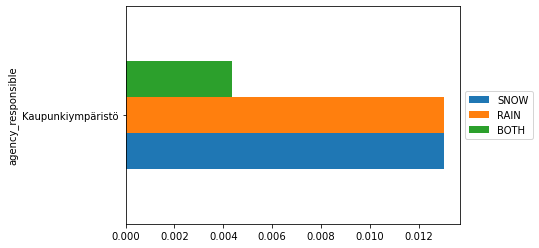

In [30]:
# create a column indicating if the feedback contains at least one *SNOW* or *RAIN* match
text_dict_matches_df['SNOW'] = text_dict_matches_df['Weather Indicators'].apply(lambda matches: 'SNOW' in set([match[0] for match in matches]))
text_dict_matches_df['RAIN'] = text_dict_matches_df['Weather Indicators'].apply(lambda matches: 'RAIN' in set([match[0] for match in matches]))
text_dict_matches_df['BOTH'] = text_dict_matches_df['Weather Indicators'].apply(lambda matches: 'SNOW' in set([match[0] for match in matches]) and 'RAIN' in set([match[0] for match in matches]))

# get the relative frequency by agency
perc_winter = text_dict_matches_df.groupby('agency_responsible')['SNOW'].value_counts(normalize=True)
perc_autumn = text_dict_matches_df.groupby('agency_responsible')['RAIN'].value_counts(normalize=True)
perc_both = text_dict_matches_df.groupby('agency_responsible')['BOTH'].value_counts(normalize=True)
# combine the values into one dataframe
res = pd.concat([perc_winter, perc_autumn, perc_both], axis=1).reset_index().rename(columns={"level_1": "is_contained"})
# only use the counts for rows indicating a match
res = res[res['is_contained']].drop('is_contained', axis=1).set_index('agency_responsible')
res.plot.barh().legend(loc='center left',bbox_to_anchor=(1.0, 0.5))


Only 'Kaupunkiympäristö' feedback has dictionary matches. 1,2 % of the feedback seem to relate to SNOW and 1,2% to RAIN.
The dictionary definitely needs improvement, but you get the idea!

<a id="summary"></a>
## Summary

This notebook shows you how to use the Watson NLP library and how quickly and easily you can get started with Watson NLP by running the pretrained models for sentiment classification and entity extraction. You learned how easy you can extract custom terms using dictionaries.

### Original Authors of English NLP analysis
Simone Zerfass, IBM Germany

Alexander Lang, IBM Germany

### Adapted to Finnish NLP analysis

Sara Elo Dean, IBM Finland